In [1]:
#https://www.kaggle.com/kanatoko/unsupervised-anomaly-detection-xbos-hbos-iforest/notebook

import math
import numpy as np
from pandas import DataFrame
import datetime
from itertools import repeat



In [2]:
class HBOS:
        
    def __init__(self, log_scale=True, ranked=False, bin_info_array=[], mode_array=[], nominal_array=[]):
        self.log_scale = log_scale
        self.ranked = ranked
        self.bin_info_array = bin_info_array
        self.mode_array = mode_array
        self.nominal_array = nominal_array
        # self.histogram_list = []
        
    def fit(self, data):
        attr_size = len(data.columns)
        total_data_size = len(data)
        
        # init params if needed
        if len(self.bin_info_array) == 0:
            self.bin_info_array = list(repeat(-1, attr_size))
        
        if len(self.mode_array) == 0:
            self.mode_array = list(repeat('dynamic binwidth', attr_size))
            
        if len(self.nominal_array) == 0:
            self.nominal_array = list(repeat(False, attr_size))
        
        if self.ranked:
            self.log_scale = False
            
        normal = 1.0
        
        # calculate standard _bin size if needed
        for i in range(len(self.bin_info_array)):
            if self.bin_info_array[ i ] == -1:
                self.bin_info_array[ i ] = round(math.sqrt(len(data))) #k=racine(N)
                
        # initialize histogram
        self.histogram_list = []
        for i in range(attr_size):
            self.histogram_list.append([])
            
            #DYNAMIC BIN-WIDTH HISTOGRAM
        # save maximum value for every attribute(needed to normalize _bin width)
        maximum_value_of_rows = data.apply(max).values
        
        # sort data
        sorted_data = data.apply(sorted)
        
        # create histograms
        for attrIndex in range(len(sorted_data.columns)):
            attr = sorted_data.columns[ attrIndex ]
            last = 0
            bin_start = sorted_data[ attr ][ 0 ]
            if self.mode_array[ attrIndex ] == 'dynamic binwidth':
                if self.nominal_array[ attrIndex ] == True:
                    while last < len(sorted_data) - 1:
                        last = self.create_dynamic_histogram(self.histogram_list, sorted_data, last, 1, attrIndex, True)
                else:
                    length = len(sorted_data)
                    binwidth = self.bin_info_array[ attrIndex ]
                    while last < len(sorted_data) - 1:
                        values_per_bin = math.floor(len(sorted_data) / self.bin_info_array[ attrIndex ]) #N/k
                        last = self.create_dynamic_histogram(self.histogram_list, sorted_data, last, values_per_bin, attrIndex, False)
                        if binwidth > 1:
                            length = length - self.histogram_list[ attrIndex ][ -1 ].quantity
                            binwidth = binwidth - 1
            else:
                count_bins = 0
                binwidth = (sorted_data[ attr ][ len(sorted_data) - 1 ] - sorted_data[ attr ][ 0 ]) / self.bin_info_array[ attrIndex ]
                if (self.nominal_array[ attrIndex ] == True) | (binwidth == 0):
                    binwidth = 1
                while last < len(sorted_data):
                    is_last_bin = count_bins == self.bin_info_array[ attrIndex ] - 1
                    last = self.create_static_histogram(self.histogram_list, sorted_data, last, binwidth, attrIndex, bin_start, is_last_bin)
                    bin_start = bin_start + binwidth
                    count_bins = count_bins + 1
    
        # calculate score using normalized _bin width
        # _bin width is normalized to the number of datapoints
        # save maximum score for every attr(needed to normalize score)
        max_score = []
        
        # loop for all histograms
        for i in range(len(self.histogram_list)):
            max_score.append(0)
            histogram = self.histogram_list[ i ]
            
            # loop for all bins
            for k in range(len(histogram)):
                _bin = histogram[ k ]
                _bin.total_data_size = total_data_size
                _bin.calc_score(maximum_value_of_rows[ i ])
                if max_score[ i ] < _bin.score:
                    max_score[ i ] = _bin.score
                    
        for i in range(len(self.histogram_list)):
            histogram = self.histogram_list[ i ]
            for k in range(len(histogram)):
                _bin = histogram[ k ]
                _bin.normalize_score(normal, max_score[ i ], self.log_scale)
                
        # if ranked
        
    def predict(self, data):
        score_array = []
        for i in range(len(data)):
            each_data = data.values[ i ]
            value = 1
            if self.log_scale | self.ranked:
                value = 0
            for attr in range(len(data.columns)):
                score = self.get_score(self.histogram_list[ attr ], each_data[ attr ]) #Histo de l'attribu + valeur de l'attribu dans l'observation (args de get_score)
#                 if self.log_scale:
                value = value + score
#                 elif self.ranked:
#                     value = value + score
#                 else:
#                     value = value * score
            score_array.append(value)
        return score_array
    
    
    ###########################################################################################
    
## return sub_scores (COPIED FROM THE PREDICT FUNCTION)
    def sub_scores(self, data):
#         score_array = []
        sub_score1=[]
        for i in range(len(data)):
            each_data = data.values[ i ]
            value = 1
            if self.log_scale | self.ranked:
                value = 0
            for attr in range(len(data.columns)):
                score = self.get_score(self.histogram_list[ attr ], each_data[ attr ]) #Histo de l'attribu + valeur de l'attribu dans l'observation (args de get_score
            
                sub_score1.append(score)
                
        return sub_score1
    
    
    def get_sub_scores(self, data):
        self.fit(data)
        return self.sub_scores(data)
#     ########################################################################################
    
    def fit_predict(self, data):
        self.fit(data)
        return self.predict(data)
                
    def get_score(self, histogram, value):
        for i in range(len(histogram) - 1):
            _bin = histogram[ i ]
            if (_bin.range_from <= value) & (value < _bin.range_to):
                return _bin.score
            
        _bin = histogram[ -1 ]
        if (_bin.range_from <= value) & (value <= _bin.range_to):
            return _bin.score
        return 0
          
    @staticmethod  
    def check_amount(sortedData, first_occurrence, values_per_bin, attr):
        # check if there are more than values_per_bin values of a given value
        if first_occurrence + values_per_bin < len(sortedData):
            if sortedData[ attr ][ first_occurrence ] == sortedData[ attr ][ first_occurrence + values_per_bin ]:
                return True
            else:
                return False
        else:
            return False
            
    @staticmethod
    def create_dynamic_histogram(histogram_list, sortedData, first_index, values_per_bin, attrIndex, isNominal):
        last_index = 0
        attr = sortedData.columns[ attrIndex ]
        
        # create new _bin
        _bin = HistogramBin(sortedData[ attr ][ first_index ], 0, 0)
            
        # check if an end of the data is near
        if first_index + values_per_bin < len(sortedData):
            last_index = first_index + values_per_bin
        else:
            last_index = len(sortedData)
    
        # the first value always goes to the _bin
        _bin.add_quantitiy(1)
        
        # for every other value
        # check if it is the same as the last value
        # if so
        #   put it into the _bin
        # if not
        #   check if there are more than values_per_bin of that value
        #   if so
        #     open new _bin
        #   if not
        #     continue putting the value into the _bin
        
        cursor = first_index
        for i in range(first_index + 1, last_index):
            if sortedData[ attr ][ i ] == sortedData[ attr ][ cursor ]:
                _bin.add_quantitiy(1)
                cursor = cursor + 1
            else:
                if HBOS.check_amount(sortedData, i, values_per_bin, attr):
                    break
                else:
                    _bin.add_quantitiy(1)
                    cursor = cursor + 1
                    
        # continue to put values in the _bin until a new values arrive
        for i in range(cursor + 1, len(sortedData)):
            if sortedData[ attr ][ i ] == sortedData[ attr ][ cursor ]:
                _bin.quantity = _bin.quantity + 1
                cursor = cursor + 1
            else:
                break
                
        # adjust range of the bins
        if cursor + 1 < len(sortedData):
            _bin.range_to = sortedData[ attr ][ cursor + 1 ]
        else:  # last data
            if isNominal:
                _bin.range_to = sortedData[ attr ][ len(sortedData) - 1 ] + 1
            else:
                _bin.range_to = sortedData[ attr ][ len(sortedData) - 1 ]
                
        # save _bin
        if _bin.range_to - _bin.range_from > 0:
            histogram_list[ attrIndex ].append(_bin)
        elif len(histogram_list[ attrIndex ]) == 0:
            _bin.range_to = _bin.range_to + 1
            histogram_list[ attrIndex ].append(_bin)
        else:
            # if the _bin would have length of zero
            # we merge it with previous _bin
            # this can happen at the end of the histogram
            lastBin = histogram_list[ attrIndex ][ -1 ]
            lastBin.add_quantitiy(_bin.quantity)
            lastBin.range_to = _bin.range_to
        
        return cursor + 1

    @staticmethod
    def create_static_histogram(histogram_list, sorted_data, first_index, binwidth, attrIndex, bin_start, last_bin):
        attr = sorted_data.columns[ attrIndex ]
        _bin = HistogramBin(bin_start, bin_start + binwidth, 0)
        if last_bin == True:
            _bin = HistogramBin(bin_start, sorted_data[ attr ][ len(sorted_data) - 1 ], 0)
        
        last = first_index - 1
        cursor = first_index
        
        while True:
            if cursor >= len(sorted_data):
                break
            if sorted_data[ attr ][ cursor ] > _bin.range_to:
                break
            _bin.quantity = _bin.quantity + 1
            last = cursor
            cursor = cursor + 1
            
        histogram_list[ attrIndex ].append(_bin)
        return last + 1                 
       

class HistogramBin:

    def __init__(self, range_from, range_to, quantity):
        self.range_from = range_from
        self.range_to = range_to
        self.quantity = quantity
        self.score = 0
        self.total_data_size = 0
        
    def get_height(self):
        width = self.range_to - self.range_from
        height = self.quantity / width
        return height
    
    def add_quantitiy(self, anz):
        self.quantity = self.quantity + anz
        
    def calc_score(self, max_score):
        if max_score == 0:
            max_score = 1
        
        if self.quantity > 0:
            self.score = self.quantity / ((self.range_to - self.range_from) * self.total_data_size / abs(max_score))
        
    def normalize_score(self, normal, max_score, log_scale):
        self.score = self.score * normal / max_score
        if(self.score == 0):
            return
        self.score = 1 / self.score
        if log_scale:
            self.score = math.log10(self.score)


In [3]:
# DATASET
import pandas as pd
# dataset = pd.read_csv( "dataset_hbos.csv")
dataset = pd.read_csv( "transactions2018.csv")
dataset=dataset[dataset["Account_No"]=="A"]
orig = dataset.copy()

In [4]:
del dataset['TRANSACTION_DETAILS']
del dataset['AMOUNT']
del dataset['type']
# del dataset["month"]
del dataset["year"]
del dataset["DATE"]
del dataset["Account_No"]
del dataset["index"]

In [5]:
dataset.reset_index(drop=True, inplace=True)


In [6]:
dataset[:2]

,WITHDRAWAL_AMT,DEPOSIT_AMT,BALANCE_AMT,month,day
0,2000.0,0.0,20000.0,1,1
1,4000.0,0.0,16000.0,1,1


In [7]:
# Execute HBOS
hbos = HBOS()
hbos_result = hbos.fit_predict(dataset)

In [8]:
hbos_subscores= hbos.get_sub_scores(dataset)

In [9]:
len(hbos_subscores)

520

In [10]:
len(hbos_result)

104

In [11]:
len(hbos_subscores)/len(hbos_result)

5.0

In [12]:
sub_withdrawal_amt=hbos_subscores[:len(hbos_result)]
sub_deposit_amt=hbos_subscores[len(hbos_result):len(hbos_result)*2]
sub_balance=hbos_subscores[len(hbos_result)*2:len(hbos_result)*3]
sub_month=hbos_subscores[len(hbos_result)*3:len(hbos_result)*4]
sub_day=hbos_subscores[len(hbos_result)*4:]

In [13]:
sub_day[:12]

[1.3704514044224498,
 0.3010299956639812,
 0.3010299956639812,
 0.5672978850687503,
 0.0,
 0.0,
 0.43669259766405427,
 0.0,
 0.0,
 1.60621595109912,
 0.0,
 0.1249387366083]

In [14]:
# Merge HBOS result with labeld data( orig ) for evaluation¶
hbos_orig = orig.copy()
hbos_orig['hbos'] = hbos_result
hbos_orig['sub_withdrawal_amt'] = sub_withdrawal_amt
hbos_orig['sub_deposit_amt'] =sub_deposit_amt
hbos_orig['sub_balance'] = sub_balance
hbos_orig['sub_month'] = sub_month
hbos_orig['sub_day'] = sub_day

In [15]:
# View merged data
hbos_orig[:2]

,index,Account_No,DATE,TRANSACTION_DETAILS,WITHDRAWAL_AMT,DEPOSIT_AMT,BALANCE_AMT,year,month,day,type,AMOUNT,hbos,sub_withdrawal_amt,sub_deposit_amt,sub_balance,sub_month,sub_day
35517,35517,A,2018-01-01 00:00:00,INDO GIBL Indiaforensic STL31121,2000.0,0.0,20000.0,2018,1,1,CASH_OUT,2000.0,1.154902,0.0,1.079181,0.346787,0.088727,1.370451
35518,35518,A,2018-01-01 00:00:00,INDO GIBL Indiaforensic STL30121,4000.0,0.0,16000.0,2018,1,1,PAYEMENT,4000.0,2.607042,0.0,0.000000,0.815940,0.397940,0.301030


In [16]:
# Sort by HBOS anomaly score and take top 1000 data for evaluation
hbos_top1000_data = hbos_orig.sort_values(by=['hbos'],ascending=False)[:1000]

In [17]:
hbos_top1000_data[:15]


,index,Account_No,DATE,TRANSACTION_DETAILS,WITHDRAWAL_AMT,DEPOSIT_AMT,BALANCE_AMT,year,month,day,type,AMOUNT,hbos,sub_withdrawal_amt,sub_deposit_amt,sub_balance,sub_month,sub_day
35589,35589,A,2018-09-20 00:00:00,FDRL/INTERNAL FUND TRANSFE,9000.0,0.0,-16440.0,2018,9,20,CHECK_WITHDRAWAL,9000.0,4.975432,0.544894,0.000000,0.896251,0.000000,0.000000
35562,35562,A,2018-06-28 00:00:00,FDRL/INTERNAL FUND TRANSFE,5000.0,0.0,-14000.0,2018,6,28,CHECK_WITHDRAWAL,5000.0,4.845098,1.606216,0.000000,0.259637,0.088727,0.000000
35536,35536,A,2018-03-19 00:00:00,INDO GIBL Indiaforensic STL18031,10000.0,0.0,-4500.0,2018,3,19,CHECK_WITHDRAWAL,10000.0,4.450619,0.815940,0.425969,0.698970,0.000000,0.000000
35530,35530,A,2018-02-28 00:00:00,FDRL/INTERNAL FUND TRANSFE,0.0,10000.0,16000.0,2018,2,28,TRANSFER,10000.0,4.149220,0.455932,0.286307,0.000000,2.720159,0.000000
35582,35582,A,2018-08-29 00:00:00,INDO GIBL Indiaforensic STL28081,6000.0,0.0,8600.0,2018,8,29,CASH_OUT,6000.0,4.019851,0.896251,0.815940,0.259637,0.088727,0.000000
35545,35545,A,2018-04-27 00:00:00,FDRL/INTERNAL FUND TRANSFE,0.0,10000.0,1400.0,2018,4,27,TRANSFER,10000.0,4.011055,0.455932,0.000000,0.000000,1.606216,1.037789
35537,35537,A,2018-03-28 00:00:00,FDRL/INTERNAL FUND TRANSFE,0.0,10000.0,5500.0,2018,3,28,TRANSFER,10000.0,3.875393,1.424209,1.079181,0.346787,0.301030,0.000000
35588,35588,A,2018-09-10 00:00:00,Indfor INCOME INDO REMI07091,3240.0,0.0,-7440.0,2018,9,10,DEBIT,3240.0,3.865791,0.000000,1.339948,1.079181,0.301030,0.146128
35590,35590,A,2018-09-28 00:00:00,FDRL/INTERNAL FUND TRANSFE,0.0,15000.0,-1440.0,2018,9,28,TRANSFER,15000.0,3.832641,0.425969,0.698970,1.172962,0.000000,1.037789
35579,35579,A,2018-08-16 00:00:00,Indfor INCOME INDO REMI14081,3600.0,0.0,-6400.0,2018,8,16,CASH_OUT,3600.0,3.824398,0.301030,0.000000,0.000000,0.000000,0.000000


In [18]:
import seaborn as sns


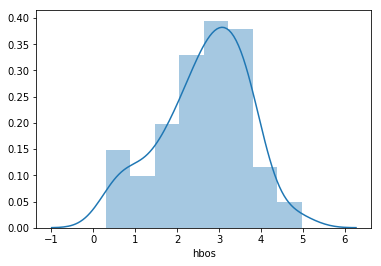

In [19]:
# hbos_top1000_data[:15]
#thresholds
sns.distplot(hbos_top1000_data["hbos"])



In [21]:
q4=hbos_top1000_data["hbos"].quantile(.75)
q4

3.443266582036263

In [22]:
hbos_top1000_data[hbos_top1000_data["hbos"]>q4].shape

(26, 18)

In [114]:
#hbos_top1000_data["threshold"] is 1 if transaction is suspicious and 0 otherwise

hbos_top1000_data["threshold"]=0
cond_q=hbos_top1000_data["hbos"]>q4
hbos_top1000_data["threshold"]=hbos_top1000_data["threshold"].mask(cond_q,1)

In [115]:
hbos_top1000_data.to_csv("hbo_result_1year_1client.csv", index = None, header=True)

In [24]:
client=hbos_top1000_data[hbos_top1000_data["Account_No"]=="409000438620'"]

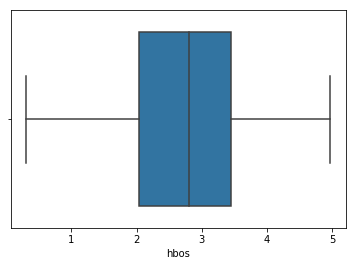

In [23]:
sns.boxplot(hbos_top1000_data["hbos"])

In [25]:
# hbos_top1000_data[hbos_top1000_data["threshold"]>q4]

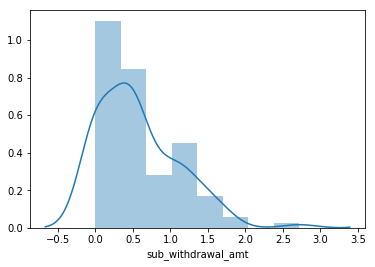

In [26]:
sns.distplot(hbos_top1000_data["sub_withdrawal_amt"])

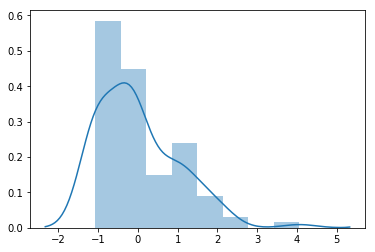

In [27]:
from scipy import stats
sns.distplot(stats.zscore(hbos_top1000_data["sub_withdrawal_amt"]))

In [29]:
test_observation=pd.DataFrame()
test_observation["WITHDRAWAL_AMT"]=[2000.0, 0.0, 300000]
test_observation["DEPOSIT_AMT"]=[0.0, 5000, 0.0]
test_observation["BALANCE_AMT"]=[20000.0, 20500.0, -500]
test_observation["month"]=[1, 13, 1]
test_observation["day"]=[1, 1, 1]

In [30]:
test_observation

,WITHDRAWAL_AMT,DEPOSIT_AMT,BALANCE_AMT,month,day
0,2000.0,0.0,20000.0,1,1
1,0.0,5000.0,20500.0,13,1
2,300000.0,0.0,-500.0,1,1


In [31]:
hbos_TESTresult = hbos.predict(test_observation)

In [32]:
hbos_TESTresult

[1.1549019599857433, 2.0692125631271763, 0.5808706922580243]

In [33]:
hbos_subscoresTEST= hbos.get_sub_scores(test_observation)

In [34]:
sub_withdrawal_amt=hbos_subscoresTEST[:len(hbos_TESTresult)]
sub_deposit_amt=hbos_subscoresTEST[len(hbos_TESTresult):len(hbos_TESTresult)*2]
sub_balance=hbos_subscoresTEST[len(hbos_TESTresult)*2:len(hbos_TESTresult)*3]
sub_month=hbos_subscoresTEST[len(hbos_TESTresult)*3:len(hbos_TESTresult)*4]
sub_day=hbos_subscoresTEST[len(hbos_TESTresult)*4:]

In [36]:
# print(len(hbos_top1000_data[lambda x:x['Class']==1]))
# Merge HBOS result with labeld data( orig ) for evaluation¶
hbosTEST_orig = test_observation.copy()
hbosTEST_orig['hbos'] = hbos_TESTresult
hbosTEST_orig['sub_withdrawal_amt'] = sub_withdrawal_amt
hbosTEST_orig['sub_deposit_amt'] =sub_deposit_amt
hbosTEST_orig['sub_balance'] = sub_balance
hbosTEST_orig['sub_month'] = sub_month
hbosTEST_orig['sub_day'] = sub_day

In [37]:
# print(len(hbos_orig[lambda x:x['Class']==1]))
hbosTEST_orig

,WITHDRAWAL_AMT,DEPOSIT_AMT,BALANCE_AMT,month,day,hbos,sub_withdrawal_amt,sub_deposit_amt,sub_balance,sub_month,sub_day
0,2000.0,0.0,20000.0,1,1,1.154902,2.173186,0.0,0.0,0.000000,1.612784
1,0.0,5000.0,20500.0,13,1,2.069213,0.000000,0.0,0.0,2.173186,0.000000
2,300000.0,0.0,-500.0,1,1,0.580871,0.000000,0.0,0.0,0.000000,0.000000


In [38]:
np.max(hbos_top1000_data["sub_month"])

2.720159303405957

In [28]:
# from matplotlib import pyplot as plt
# print(hbos_top1000_data['Class'].cumsum().sum())
# plt.scatter(range(1000),hbos_top1000_data['Class'].cumsum(),marker='1')
# plt.xlabel('Top N data')
# plt.ylabel('Anomalies found')
# plt.show()